In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
FILE_PATH = '/content/dataset.csv'
TARGET_COLUMN = 'price_range'

In [4]:
# Load the dataset
try:
    data = pd.read_csv(FILE_PATH)
    print(f"Data loaded successfully. Shape: {data.shape}")
    print("\nInitial Data Info:")
    data.info()
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'. Please upload your dataset.")
    data = None

Data loaded successfully. Shape: (2000, 21)

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   i

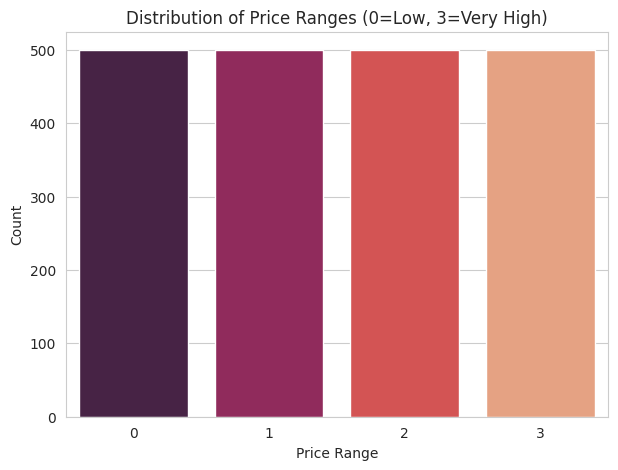

In [5]:
if data is not None:
    plt.figure(figsize=(7, 5))
    sns.countplot(x=TARGET_COLUMN, data=data, palette='rocket')
    plt.title('Distribution of Price Ranges (0=Low, 3=Very High)')
    plt.xlabel('Price Range')
    plt.ylabel('Count')
    plt.show()

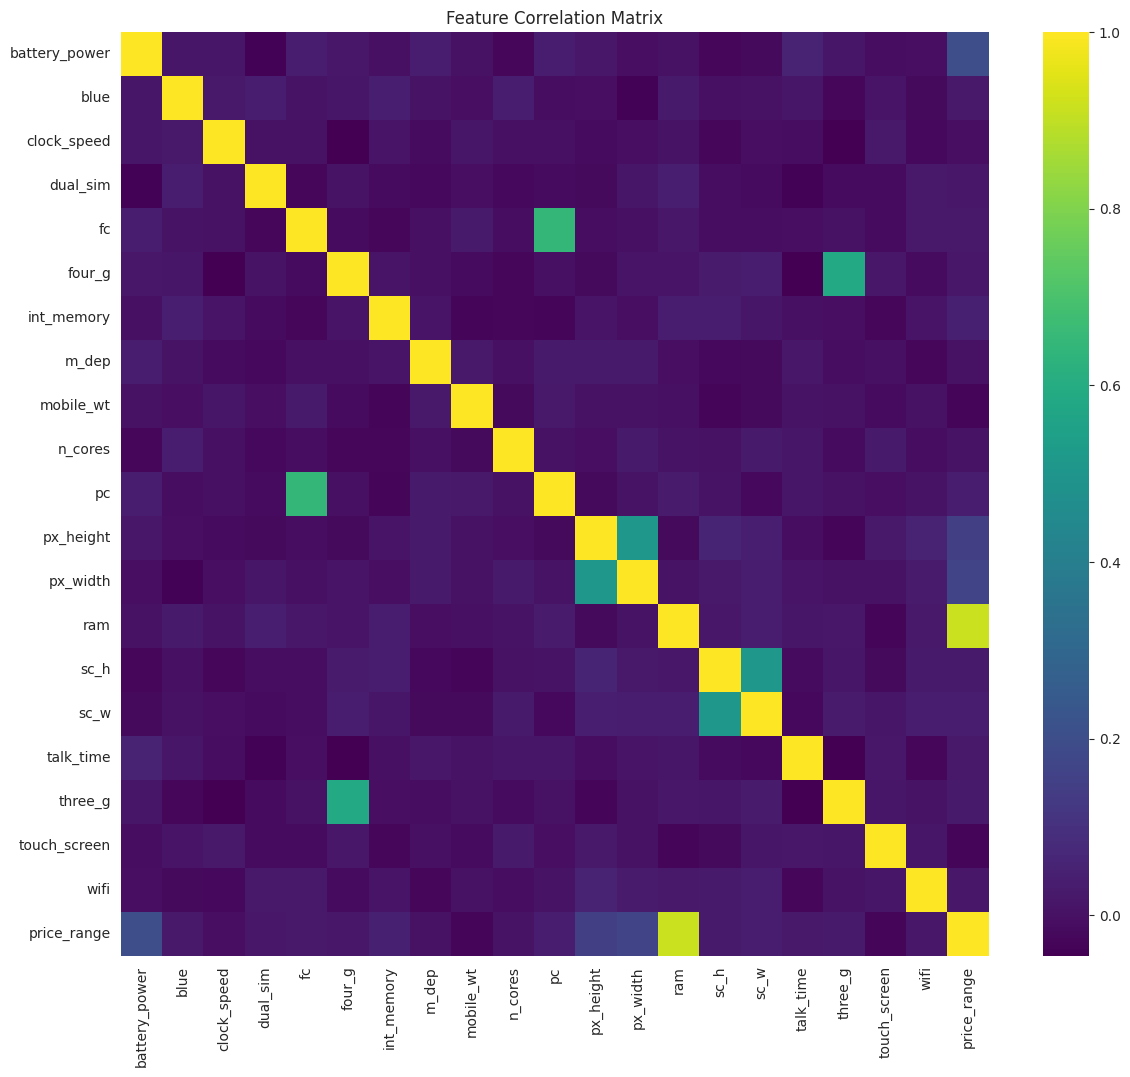

In [6]:
if data is not None:
    # Compute the correlation matrix
    corr_matrix = data.corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=False, cmap='viridis', fmt=".2f")
    plt.title('Feature Correlation Matrix')
    plt.show()

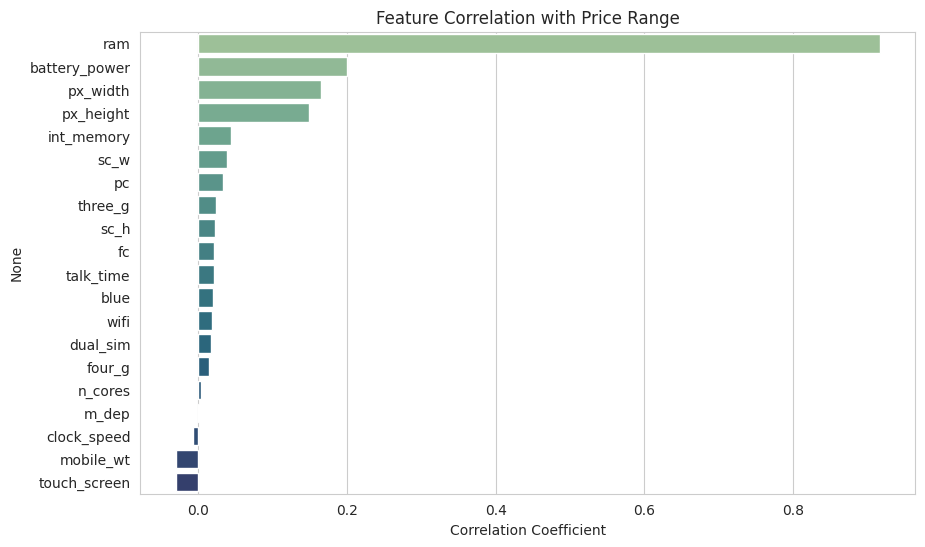

Highest correlation features are RAM, Battery Power, and Pixel Dimensions.


In [7]:
if data is not None:
    # Visualize correlation specifically with the Target
    target_corr = corr_matrix[TARGET_COLUMN].sort_values(ascending=False).drop(TARGET_COLUMN)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette='crest')
    plt.title('Feature Correlation with Price Range')
    plt.xlabel('Correlation Coefficient')
    plt.show()
    print("Highest correlation features are RAM, Battery Power, and Pixel Dimensions.")


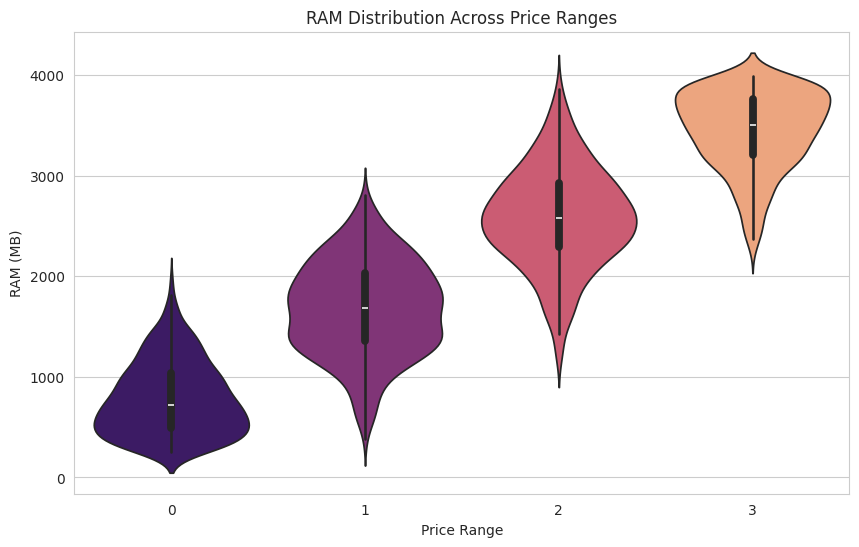

Clear separation in RAM based on price range, indicating high predictive power.


In [8]:
if data is not None:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=TARGET_COLUMN, y='ram', data=data, palette='magma')
    plt.title('RAM Distribution Across Price Ranges')
    plt.xlabel('Price Range')
    plt.ylabel('RAM (MB)')
    plt.show()
    print("Clear separation in RAM based on price range, indicating high predictive power.")


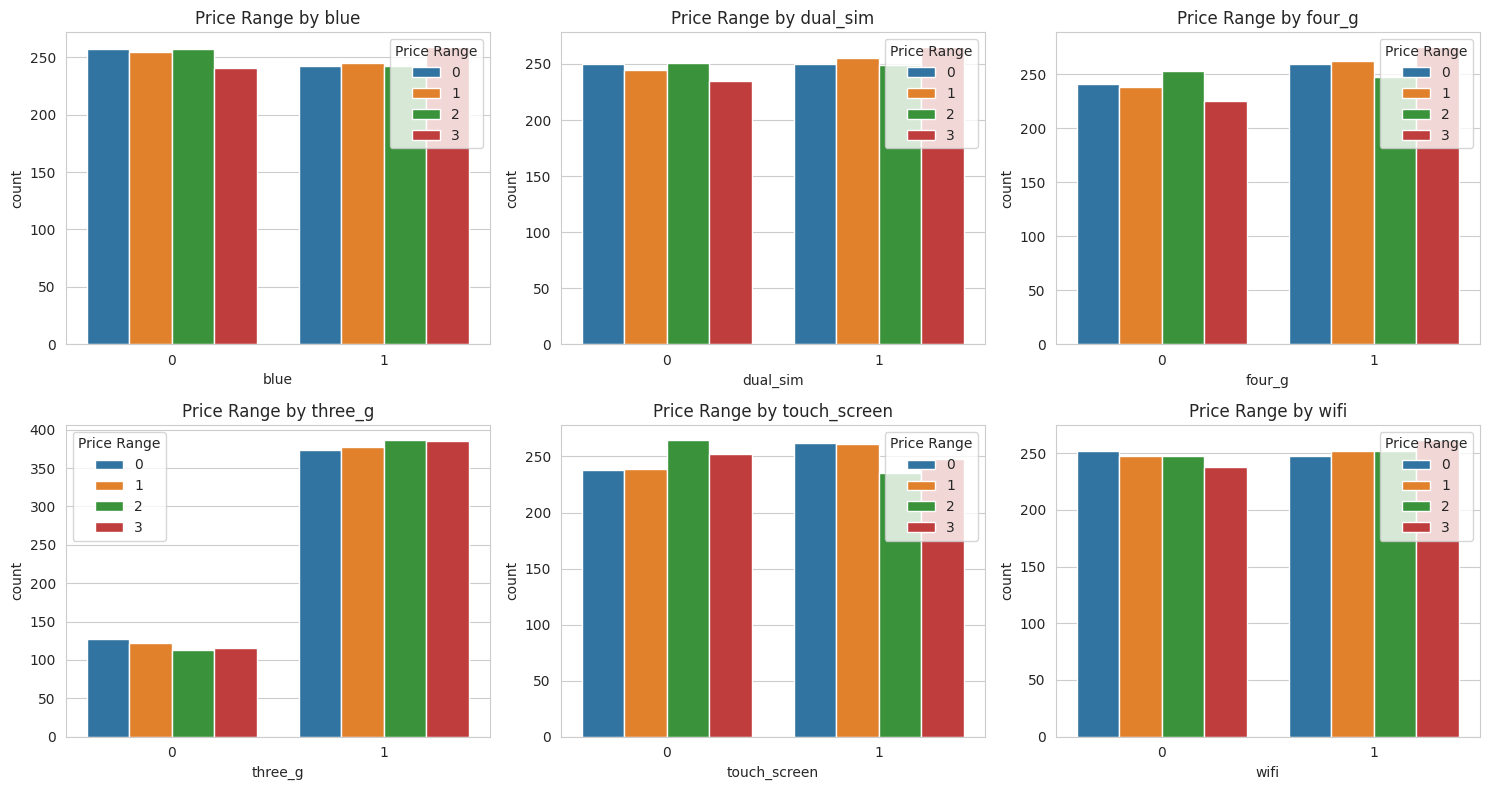

In [9]:
if data is not None:
    binary_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, col in enumerate(binary_cols):
        sns.countplot(x=col, hue=TARGET_COLUMN, data=data, ax=axes[i], palette='tab10')
        axes[i].set_title(f'Price Range by {col}')
        axes[i].legend(title='Price Range')

    plt.tight_layout()
    plt.show()

In [10]:
if data is not None:
    X = data.drop(TARGET_COLUMN, axis=1)
    y = data[TARGET_COLUMN]
    print(f"Features (X) shape: {X.shape}, Target (y) shape: {y.shape}")


Features (X) shape: (2000, 20), Target (y) shape: (2000,)


In [11]:
if data is not None:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    print("Numerical features scaled.")
    print(X_scaled.head())

Numerical features scaled.
   battery_power      blue  clock_speed  dual_sim        fc    four_g  \
0      -0.902597 -0.990050     0.830779 -1.019184 -0.762495 -1.043966   
1      -0.495139  1.010051    -1.253064  0.981177 -0.992890  0.957886   
2      -1.537686  1.010051    -1.253064  0.981177 -0.532099  0.957886   
3      -1.419319  1.010051     1.198517 -1.019184 -0.992890 -1.043966   
4       1.325906  1.010051    -0.395011 -1.019184  2.002254  0.957886   

   int_memory     m_dep  mobile_wt   n_cores        pc  px_height  px_width  \
0   -1.380644  0.340740   1.349249 -1.101971 -1.305750  -1.408949 -1.146784   
1    1.155024  0.687548  -0.120059 -0.664768 -0.645989   0.585778  1.704465   
2    0.493546  1.381165   0.134244  0.209639 -0.645989   1.392684  1.074968   
3   -1.215274  1.034357  -0.261339  0.646842 -0.151168   1.286750  1.236971   
4    0.658915  0.340740   0.021220 -1.101971  0.673534   1.268718 -0.091452   

        ram      sc_h      sc_w  talk_time   three_g  touch

In [12]:
if data is not None:
    # 75% training, 25% testing
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")


Training set size: 1500
Testing set size: 500


In [13]:
if data is not None:
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr'),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'LightGBM': lgb.LGBMClassifier(random_state=42, n_estimators=100, objective='multiclass', num_class=4, verbose=-1),
        'Linear SVM': SVC(random_state=42, kernel='linear', C=1.0) # Using linear kernel for speed
    }

    results = {}
    print("Model list initialized.")

Model list initialized.



--- Logistic Regression Results ---
Accuracy: 0.7940
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       125
           1       0.68      0.63      0.65       125
           2       0.65      0.58      0.61       125
           3       0.87      0.99      0.93       125

    accuracy                           0.79       500
   macro avg       0.78      0.79      0.79       500
weighted avg       0.78      0.79      0.79       500


--- K-Nearest Neighbors Results ---
Accuracy: 0.5500
              precision    recall  f1-score   support

           0       0.68      0.74      0.70       125
           1       0.42      0.46      0.44       125
           2       0.41      0.38      0.40       125
           3       0.71      0.62      0.66       125

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.55       500
weighted avg       0.55      0.55      0.55       500


--- Decision Tree Res

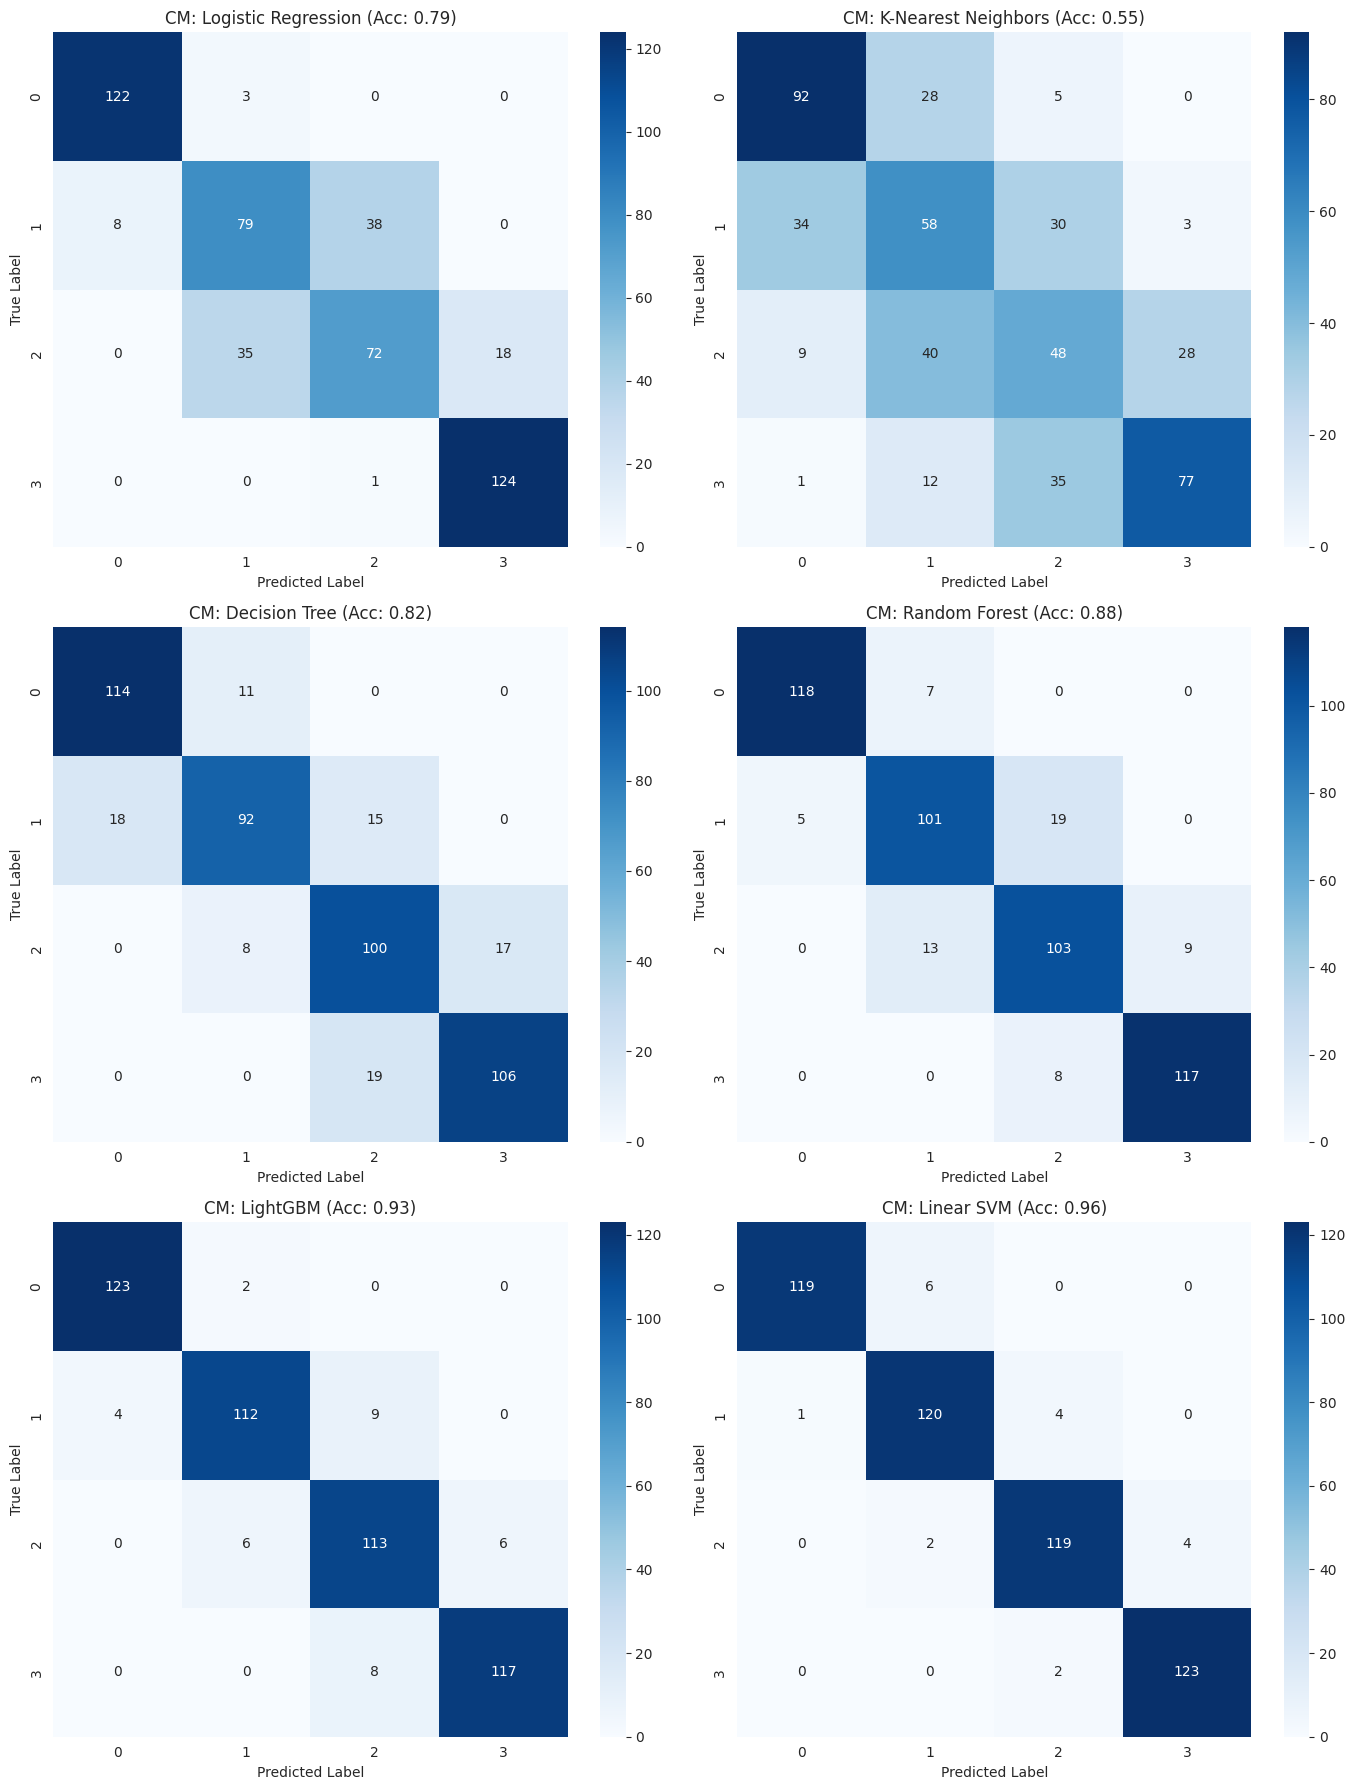

In [14]:
if data is not None:
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    axes = axes.flatten()

    for i, (name, model) in enumerate(models.items()):
        # Train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate Metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Store F1-score for comparison (using macro average for multi-class)
        results[name] = {'Accuracy': accuracy, 'F1_Score': report['macro avg']['f1-score']}

        print(f"\n--- {name} Results ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Confusion Matrix Visualization
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
        axes[i].set_title(f'CM: {name} (Acc: {accuracy:.2f})')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [15]:
if data is not None:
    performance_df = pd.DataFrame(results).T.sort_values(by='F1_Score', ascending=False)
    print("\n--- Final Model Performance Summary ---")
    print(performance_df)


--- Final Model Performance Summary ---
                     Accuracy  F1_Score
Linear SVM              0.962  0.962059
LightGBM                0.930  0.930075
Random Forest           0.878  0.878216
Decision Tree           0.824  0.823465
Logistic Regression     0.794  0.787191
K-Nearest Neighbors     0.550  0.550513


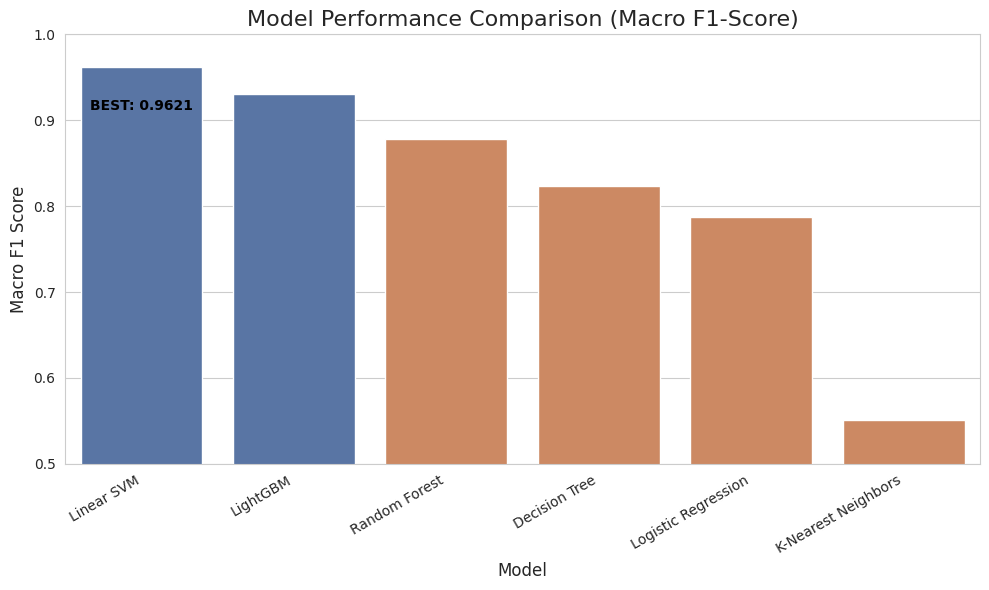


--- Conclusion ---
The best model for predicting mobile phone pricing is the Linear SVM, achieving an F1-Score of 0.9621.


In [16]:
if data is not None:
    # Prepare data for plotting
    models_names = performance_df.index
    f1_scores = performance_df['F1_Score'].values

    plt.figure(figsize=(10, 6))

    # Define colors based on rank
    colors = ['#4c72b0' if i < 2 else '#dd8452' for i in range(len(models_names))]

    sns.barplot(x=models_names, y=f1_scores, palette=colors)

    plt.title('Model Performance Comparison (Macro F1-Score)', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Macro F1 Score', fontsize=12)
    plt.ylim(0.5, 1.0)
    plt.xticks(rotation=30, ha='right')

    # Highlight the best model
    best_model_name = models_names[0]
    best_f1 = f1_scores[0]
    plt.text(0, best_f1 - 0.05, f'BEST: {best_f1:.4f}', ha='center', color='black', weight='bold')

    plt.tight_layout()
    plt.show()

    print("\n--- Conclusion ---")
    print(f"The best model for predicting mobile phone pricing is the {best_model_name}, achieving an F1-Score of {best_f1:.4f}.")
